# Precomputed Reactivity for a Control Rod Ejection

In [5]:
import numpy as np

t_load, rho_imp_load, gen_time_load, pow_norm_load, \
relative_power_load = np.loadtxt("cr_ejection_parcs.txt",
                                 unpack=True,skiprows=2)

t_step = 100
t = np.linspace(0,max(t_load),int(max(t_load))*t_step+1)

rho_imp_parcs = np.interp(t,t_load,rho_imp_load)

rho_imp = np.copy(rho_imp_parcs)
rho_max = max(rho_imp_parcs)
for i in range(len(rho_imp)):
    if (rho_imp[i] >= rho_max):
        break
rho_imp[i:] = rho_max

gen_time = np.interp(t,t_load,gen_time_load)
pow_norm = np.interp(t,t_load,pow_norm_load)
relative_power = np.interp(t,t_load,relative_power_load)


t = t[:6*t_step]
rho_imp = rho_imp[:6*t_step]
rho_imp_parcs = rho_imp_parcs[:6*t_step]
gen_time = gen_time[:6*t_step]
pow_norm = pow_norm[:6*t_step]
relative_power = relative_power[:6*t_step]

class Precursor:
    def __init__(self, decay_constant, beta):
        self.decay_constant = decay_constant
        self.beta = beta

precursors = [Precursor(0.0128, 0.02584e-2), Precursor(0.0318, 0.152e-2),
              Precursor(0.119, 0.13908e-2), Precursor(0.3181, 0.30704e-2),
              Precursor(1.4027, 0.1102e-2), Precursor(3.9286, 0.02584e-2)]
beta_sum = sum([p.beta for p in precursors])
beta_eff = beta_sum * np.ones(len(t))
lambduh_h = 0.29 * np.ones(len(t))
rho_imp *= beta_sum
gamma_d = -1.22 * beta_sum

# Write Input Data to XML File

In [6]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

def write_input_xml(t, rho_imp, power_history, 
                    precursors, concentration_histories, thet, 
                    beta_sum, gamma_d, lambduh_h,
                    gen_time=None, pow_norm=None):
    epke_input = ET.Element("epke_input", n_steps=str(len(t)), 
                            theta=str(thet), gamma_d=str(gamma_d),
                            eta="1.0", outpath="examples/epke_output.xml")
    
    ET.SubElement(epke_input, "time").text = ' '.join(map(str, t))
    ET.SubElement(epke_input, "rho_imp").text = ' '.join(map(str, rho_imp))
    
    if (gen_time is not None):
        ET.SubElement(epke_input, "gen_time").text = ' '.join(map(str, gen_time))
    else:
        ET.SubElement(epke_input, "gen_time", value="1.58e-5")
    
    if (pow_norm is not None):
        ET.SubElement(epke_input, "pow_norm").text = ' '.join(map(str, pow_norm))
    else:
        ET.SubElement(epke_input, "pow_norm", value="1.0")
    
    ET.SubElement(epke_input, "beta_eff", value=str(beta_sum))
    ET.SubElement(epke_input, "lambda_h").text = ' '.join(map(str,lambduh_h))
    ET.SubElement(epke_input, "p_history").text = ' '.join(map(str,power_history))
    
    precursors_element = ET.SubElement(epke_input, "precursors")
    concentrations_element = ET.SubElement(epke_input, "concentration_histories")
    for k, precursor in enumerate(precursors):
        ET.SubElement(precursors_element, "precursor", 
                      decay_constant=str(precursor.decay_constant), 
                      beta=str(precursor.beta),
                      k=str(k))
        ET.SubElement(concentrations_element, "concentration_history", k=str(k)).text = ' '.join(map(str, concentration_histories[k])) 
    
    # pretty print and write to xml
    xmlstr = minidom.parseString(ET.tostring(epke_input)).toprettyxml(indent="   ")
    
    with open("epke_input.xml", "w") as f:
        f.write(xmlstr)

power_history = [1e-6]
concentration_histories = []
for j, precursor in enumerate(precursors):
    initial_concentration = precursor.beta*power_history[0]/precursor.decay_constant
    concentration_histories.append([initial_concentration])
    
write_input_xml(t, rho_imp, power_history, precursors, 
                concentration_histories, 0.5, beta_sum, 
                gamma_d, lambduh_h, gen_time, pow_norm)

# Run the EPKE Executable

In [7]:
import subprocess

args = "./epke-run examples/epke_input.xml".split()
popen = subprocess.Popen(args, cwd="..", stdout=subprocess.PIPE)
popen.wait()
while True:
    line = popen.stdout.readline()
    if not line:
        break
    print(line.rstrip().decode('utf-8'))

Reading input file: examples/epke_input.xml
time: 0.1
decay_constant: 0.3181
delayed_fraction: 0.0030704
rho_imp: 2.57492e-05
gen_time: 0.948493
solving...
beta_prev_prev: 0.0002584
power_prev_prev: 1e-06
gen_time_prev_prev: 1
zeta_hat[1,0] = 2.01864e-08
beta_prev_prev: 0.00152
power_prev_prev: 1e-06
gen_time_prev_prev: 1
zeta_hat[1,1] = 4.77924e-08
beta_prev_prev: 0.0013908
power_prev_prev: 1e-06
gen_time_prev_prev: 1
zeta_hat[1,2] = 1.16816e-08
beta_prev_prev: 0.0030704
power_prev_prev: 1e-06
gen_time_prev_prev: 1
zeta_hat[1,3] = 9.63952e-09
beta_prev_prev: 0.001102
power_prev_prev: 1e-06
gen_time_prev_prev: 1
zeta_hat[1,4] = 7.81036e-10
beta_prev_prev: 0.0002584
power_prev_prev: 1e-06
gen_time_prev_prev: 1
zeta_hat[1,5] = 6.46974e-11
a1b1[1] = (-3.12503e-09, 2.57124e-05)
a, b, c = -1.56048e-11, -1.00004, 1.00004e-06
power[1] = -0
beta_prev_prev: 0.0002584
power_prev_prev: 1e-06
gen_time_prev_prev: 1
zeta_hat[2,0] = 2.01836e-08
beta_prev_prev: 0.00152
power_prev_prev: 1e-06
gen_time_

# Read the XML Output

In [13]:
tree = ET.parse('epke_output.xml')
root = tree.getroot()

for child in root:
    if (child.tag == 'time'):
        time_out = np.fromstring(child.attrib['values'], dtype=float, sep=',')
    if (child.tag == 'power'):
        p_out = np.fromstring(child.attrib['values'], dtype=float, sep=',')
    if (child.tag == 'rho'):
        rho_out = np.fromstring(child.attrib['values'], dtype=float, sep=',')

# Plot the Reactivity

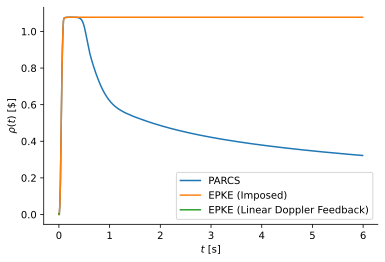

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

ax = plt.subplot(111)
ax.plot(t,rho_imp_parcs,label='PARCS')
ax.plot(t,rho_imp/beta_sum,label='EPKE (Imposed)')
ax.plot(t,rho_out/beta_sum,label='EPKE (Linear Doppler Feedback)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('$t$ [s]')
plt.ylabel('$\\rho(t)$ [\$]')
plt.legend()
plt.savefig('rho_doppler.pgf',bbox_inches='tight',transparent=True)
plt.show()

# Plot the Power

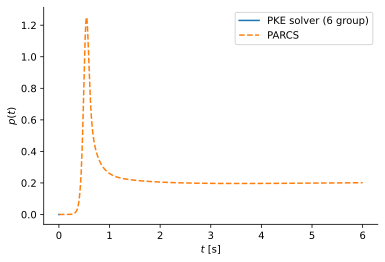

In [6]:
ax = plt.subplot(111)
ax.plot(t,p_out,label='PKE solver (6 group)')
ax.plot(t,relative_power,label='PARCS',linestyle='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('$t$ [s]')
plt.ylabel('$p(t)$')
plt.legend()
plt.savefig('power_doppler.pgf',bbox_inches='tight',transparent=True)
plt.show()